$$\|P(t_1, t_0, \vec x_i(t_0)) - \vec x_i(t_1)\| \le \tt{search\_range}$$

In [83]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
from collections import namedtuple
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import linregress
import imageio

%matplotlib inline

# Optionally, tweak styles.
rc('animation', html='html5')
mpl.rc('figure',  figsize=(5, 10))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
import trackpy as tp
import seaborn as sns

from pandas import DataFrame, Series  # for convenience
import os
from ntpath import basename

import pims
import glob
from sxmreader import SXMReader

Params = namedtuple(
    'Params', 
    ['molecule_size', 
     'min_mass',
     'max_mass',
     'separation',
     'min_size',
     'max_ecc',
     'adaptive_stop',
     'search_range'])

voltage = np.linspace(25, 29, 5, dtype=np.float32)
START = 339
SIZE = 1
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltage))]
params = [
        Params(#molecule_size = 11,
            #min_mass = 1,
            #max_mass = 9,
            #min_size = 0.5,
            #max_ecc = 1,
            #separation = 5,
            #search_range = 100,
            #adaptive_stop = 2,
            molecule_size = 9,
            min_mass = 1,
            max_mass = 8,
            min_size = 0.5,
            max_ecc = 1,
            separation = 5,
            search_range = 50,
            adaptive_stop = 5
           ) for i in range(len(voltage))
         ]
n_range = [i for i in sets]
SXM_PATH = [["electromigration_23/Image_{0:03}.sxm".format(i) for i in n_range[j]] for j in range(len(n_range))]


In [84]:
sets

[range(339, 341),
 range(340, 342),
 range(341, 343),
 range(342, 344),
 range(343, 345)]

In [85]:
voltage

array([25., 26., 27., 28., 29.], dtype=float32)

In [86]:
intercepts=[]
slopes=[]
DIFFUSION_TIME = 1 # in seconds
D_constants = []
indices = []
ems = []
idx = 0
references = [9, 9, 8, 7, 7, 6, 8, 8]
references = [None for _ in enumerate(sets)]
for i, path in enumerate(SXM_PATH):
    frames = SXMReader(path)
    NM_PER_PIXEL = frames.meters_per_pixel * 1e9
#     if i == 0:
#         frames[0] = frames[0][::-1]
#     if i==1:
#         frames.z_data[5][158,:] = 0
#         frames.z_data[4][156,:] = 0
#         frames.z_data[4][155,:] = 0
#         frames.z_data[4][151,:] = 0
    molecule_size, min_mass, max_mass, separation, min_size, max_ecc, adaptive_stop, search_range = params[i]
    if separation:
        f = tp.batch(frames[:], molecule_size, minmass=min_mass, separation=separation)
    else:
        f = tp.batch(frames[:], molecule_size, minmass=min_mass)
    t = tp.link(f, search_range=search_range, adaptive_stop=adaptive_stop)    
#     t = tp.find_link(f, search_range=search_range)    
    t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
    t2 = tp.filter_stubs(t, 1)
    if references[i]:
        d = tp.compute_drift(t2[t2.particle == references[i]])
    else:
        d = tp.compute_drift(t2)
    t3 = tp.subtract_drift(t2.copy(), d)
    #t3=t2
    m = tp.imsd(t3, NM_PER_PIXEL * 1e-3,1 / 60) * 1e6
    em = tp.emsd(t3, frames.meters_per_pixel*1e9, 1)
    slope, intercept, _, _, _ = linregress(em.index, em)
    intercepts.append(intercept)
    slopes.append(slope)
#     ax.plot(em.index, em, 'o-', label= "{:.2f} V_SD".format(voltage[idx]))
#     normal_particles = tp.is_typical(m, SIZE-1, lower=0, upper=1)
#     normal_particles = normal_particles[normal_particles].index
#     t3 = t3[t3.particle.isin(normal_particles)]
#     t3 = t3.reset_index().set_index('frame', drop=False)
#     t3 = t3[t3.particle != 9]
    displacements = tp.relate_frames(t3, 0, 1) * NM_PER_PIXEL
    for i in range(t3.frame.max() - 1):
        try:
            displacements = displacements.append(tp.relate_frames(t3, i, i + 1) * NM_PER_PIXEL, ignore_index=True)
        except:
            print("skipped {}".format(i))
    D_constants.append((displacements.dx.var() + displacements.dy.var()) / 4) # r^2 = x^2 + y^2 = 2Dt + 2Dt
    idx=idx+1
D_constants = np.array(D_constants) / DIFFUSION_TIME

Frame 1: 28 trajectories present.


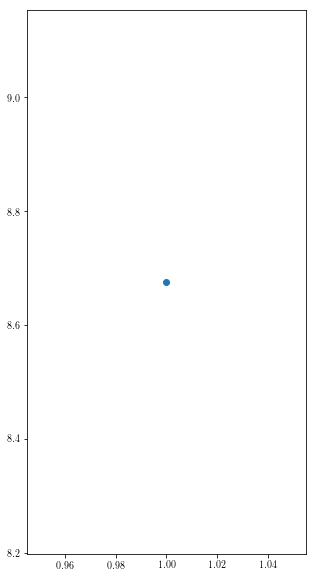

In [87]:
plt.plot(em.index, np.sqrt(em), 'o-')

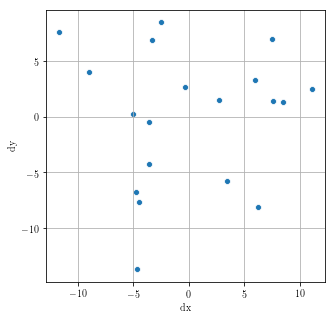

In [88]:
plt.figure(figsize=(5, 5))
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)
plt.grid()
sns.scatterplot(x='dx', y='dy', data=displacements)

-891.7462409687814
33.22278232892056


Text(350, 500, 'ln(D)= -891.75 $\\frac{1}{T}$+ 33.22')

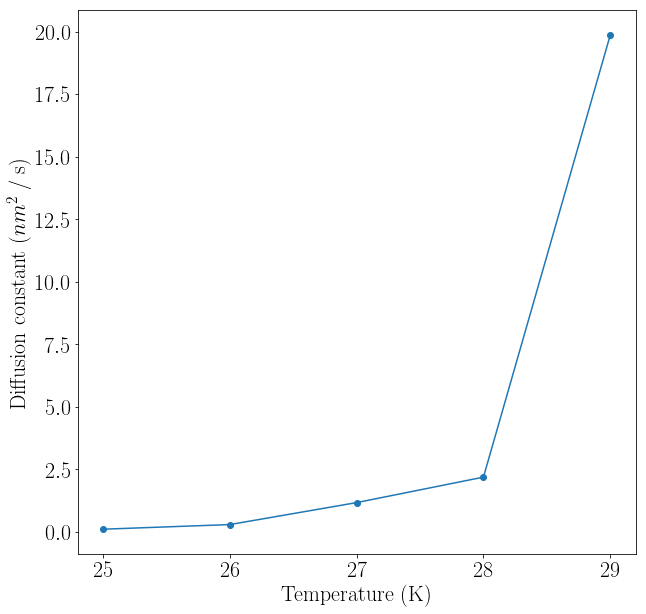

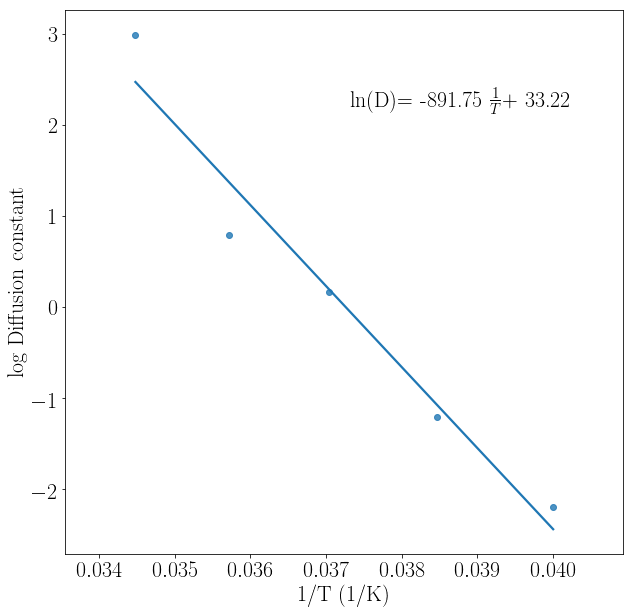

In [89]:
import seaborn as sns
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex =True)
fig, ax = plt.subplots(figsize=(10,10))
# ax.plot(np.arange(2.2,4.3,0.3), D_constants,'o-')
tmpv, _D_constants = (list(t) for t in zip(*sorted(zip(voltage[:], D_constants[:]))))
ax.plot(np.array(tmpv), _D_constants,'o-')
plt.xlabel('Temperature (K)')
plt.ylabel('Diffusion constant ($nm^2$ / s)')

fig, ax1 = plt.subplots(figsize=(10,10))
sns.regplot(np.reciprocal(tmpv), np.log(_D_constants), 'o-', ci=None, ax=ax1)
result = linregress(np.reciprocal(tmpv), np.log(_D_constants))
print(result.slope)
print(result.intercept)
# upper = np.log(D_constants + D_constants / np.sqrt(np.array(Ns)[:,-1])) - np.log(D_constants)
# lower = np.log(D_constants) - np.log(D_constants - D_constants / np.sqrt(np.array(Ns)[:,-1]))
# yerr = np.stack((upper, lower))
# ax1.errorbar(np.reciprocal(tmpv), np.log(D_constants), yerr=yerr, fmt='none', color='b')
# ax1.set_yscale('log')
plt.xlabel('1/T (1/K)')
plt.ylabel('log Diffusion constant')
ax1.annotate(r'ln(D)= {slope:.2f} $\frac{{1}}{{T}}$+ {intercept:.2f}'.format(slope=result.slope,intercept = result.intercept),xy=(350,500), xycoords='figure pixels')
#ax1.annotate('ln(D)aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',xy=(100,100),xycoords='figure pixels')
# fig, ax = plt.subplots(figsize=(5,5))
# ax.plot(tmpv ,powers,'x-')
# plt.xlabel('V_SD (V)')
# plt.ylabel('power law')

In [90]:
result = linregress(np.reciprocal(tmpv), np.log(_D_constants))

In [65]:
result.intercept

41.39757615174854

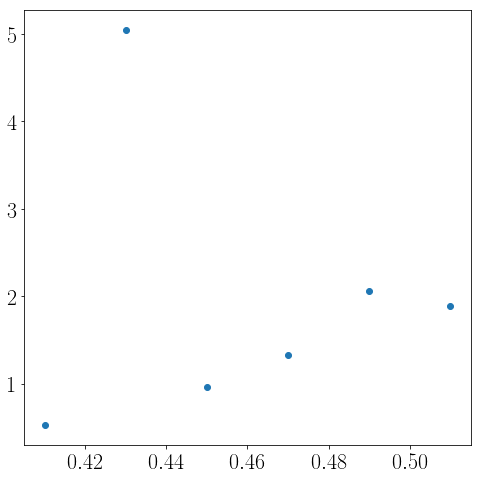

In [46]:
plt.figure(figsize=(8, 8))
plt.plot(voltage, _D_constants / np.array([0.0881857 , 0.01721636, 0.30606802, 0.41797495, 0.71354962,
       1.37261721]), 'o')
         
         #np.array([0.06976049, 0.04715673, 0.02664969, 0.23858728, 0.24287609,
       #0.74152065, 1.44926469]), 'o')
#np.array([0.07271994, 0.10490607, 0.09135322, 0.33101666, 1.03049401,
#       0.74599307]), 'o')

Text(0, 0.5, '$D / v_{drift}\\ (nm)$')

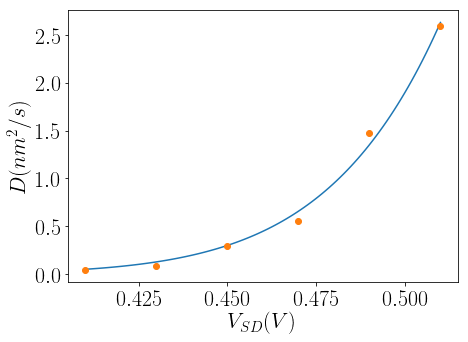

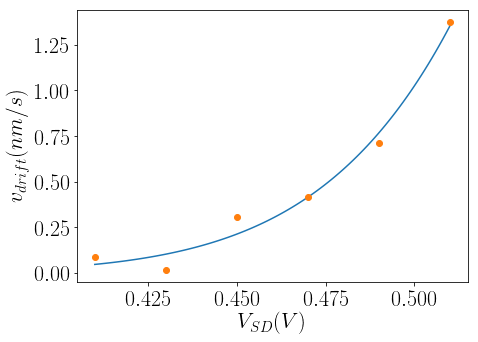

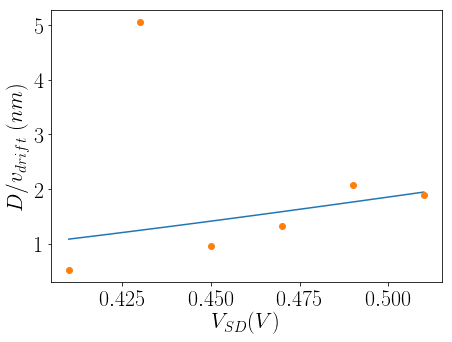

In [51]:
import scipy
def exponenial_func(x, a, b):
    return a * np.exp(-b / x )

plt.figure(figsize=(7,5))
popt, pcov = scipy.optimize.curve_fit(exponenial_func, tmpv[:], D_constants[:])

xx = np.linspace(voltage[0], voltage[-1], 100)
yy = exponenial_func(xx, *popt)
plt.plot(xx, yy)
plt.plot(tmpv, np.array(D_constants), 'o')
plt.xlabel('$V_{SD} (V)$')
plt.ylabel('$D (nm^2/s)$')

plt.figure(figsize=(7,5))
v_drift = np.array([0.0881857 , 0.01721636, 0.30606802, 0.41797495, 0.71354962,
       1.37261721])
popt1, pcov1 = scipy.optimize.curve_fit(exponenial_func, tmpv[:], v_drift[:])
                   
xx1 = np.linspace(voltage[0], voltage[-1], 100)
yy1 = exponenial_func(xx1, *popt1)
plt.plot(xx1, yy1)
plt.plot(tmpv, v_drift, 'o')
plt.xlabel('$V_{SD} (V)$')
plt.ylabel('$v_{drift} (nm/s)$')

plt.figure(figsize=(7,5))
xx2 = np.linspace(voltage[0], voltage[-1], 100)
yy2 = exponenial_func(xx2, *popt)/exponenial_func(xx2, *popt1)
plt.plot(xx2, yy2)
plt.plot(tmpv, D_constants/v_drift, 'o')
plt.xlabel('$V_{SD} (V)$')
plt.ylabel('$D / v_{drift}\ (nm)$')


In [ ]:
plt.plot([-30, -20, -10, 0, 10], [24, 17, 11, 12, 11], 'o')
vg = np.array([-30, -20, -10, 0, 10])
T_thresh = np.array([24, 17, 11, 12, 11])
E_diff = np.array([475, 330, 200, 215, 246])
plt.plot([-30, -20, -10, 0, 10], np.array([475, 330, 200, 215, 246]) / 20, 'o')

In [ ]:
"""
Parasite axis demo

The following code is an example of a parasite axis. It aims to show a user how
to plot multiple different values onto one single plot. Notice how in this
example, par1 and par2 are both calling twinx meaning both are tied directly to
the x-axis. From there, each of those two axis can behave separately from the
each other, meaning they can take on separate values from themselves as well as
the x-axis.
"""
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 0
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par2.axis["right"].toggle(all=True)
par1.axis["right"].toggle(all=False)

host.set_xlabel("Vg")
host.set_ylabel("E_diff")
par1.set_ylabel("T_thresh")
par2.set_ylabel("T_thresh")

p1, = host.plot(vg, E_diff, 'bo', label="E_diff")
p2, = par2.plot(vg, T_thresh, 'ro', label="T_thresh")
par2.set_ylim(10,25)
host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())

plt.draw()
plt.show()